# Imports

In [6]:
using NLsolve
using LinearAlgebra
using QuantumOpticsBase
using Symbolics
using SymbolicUtils

In [7]:
import PyPlot
const plt = PyPlot;

In [8]:
include("common_code.jl");

In [9]:
include("heralded_w_state.jl");

# arbitritter

## Can we distinguish W/M states?

In [14]:
N = 6;

In [15]:
UN = symmetricunitary(N)

6×6 Matrix{Number}:
 0.408248           0.408248     …           0.408248
 0.408248   0.204124+0.353553im      0.204124-0.353553im
 0.408248  -0.204124+0.353553im     -0.204124-0.353553im
 0.408248          -0.408248                -0.408248
 0.408248  -0.204124-0.353553im     -0.204124+0.353553im
 0.408248   0.204124-0.353553im  …   0.204124+0.353553im

In [16]:
states = [
    [W(UN * [i == j ? 1 : 0 for i in 1:N]...) for j in 1:N]...,
    [M(UN * [i == j ? 1 : 0 for i in 1:N]...) for j in 1:N]...,
    [(1, [0 for _ in 1:N])],
    [(1, [1 for _ in 1:N])],
];

In [24]:
@time begin
    r = []
    Threads.@threads for state in states
         push!(r, singlephotonclicks(UN, state))
    end

    for i in 1:length(states), j in i+1:length(states)
        if commonelements(map(x->x[3], r[i]), map(x->x[3], r[j])) 
            println("i:$i, j:$j")
        end
    end
end

  0.496673 seconds (13.40 M allocations: 1.541 GiB, 43.16% gc time, 10.98% compilation time)


In [514]:
# r = []
# for state in states
#      push!(r, clicksfromfullstate(full_output_state(UN, state)))
# end

# for i in 1:length(states), j in i+1:length(states)
#     if commonelements(map(x->x[3], r[i]), map(x->x[3], r[j])) 
#         println("i:$i, j:$j")
#     end
# end

# Quitter

## Can we distinguish W/M states?

In [540]:
# Symmetric 4-port beam splitters are constrained to the following form
ϕv = 0
U = ComplexF64[
    1         1         1         1
    1   exp(1im * ϕv)  -1  -exp(1im * ϕv)
    1        -1         1        -1
    1  -exp(1im * ϕv)  -1   exp(1im * ϕv)
] / 2
# Uk = kron(U, [1 0; 0 1])
# sparsify.(convert(Array{Int}, 2U))
sparsify.(U)

4×4 Matrix{Float64}:
 0.5   0.5   0.5   0.5
 0.5   0.5  -0.5  -0.5
 0.5  -0.5   0.5  -0.5
 0.5  -0.5  -0.5   0.5

In [545]:
states = [
    [W(U * 2 * [i == j ? 1 : 0 for i in 1:4]...) for j in 1:4]...,
    [M(U * 2 * [i == j ? 1 : 0 for i in 1:4]...) for j in 1:4]...,
    GHZ(1, N=4), GHZ(2, N=4), 
    K(1), K(2), K(3), K(4), K(5), K(6)
];

In [526]:
# Us = symmetricunitary(4)

In [527]:
# states = [
      # [W(Us * [i == j ? 1 : 0 for i in 1:4]...) for j in 1:4]...,
      # [M(Us * [i == j ? 1 : 0 for i in 1:4]...) for j in 1:4]...,
#     GHZ(1, N=4), GHZ(2, N=4), 
#     K(1), K(2), K(3), K(4), K(5), K(6)
# ];

In [546]:
r = []
for state in states
     push!(r, singlephotonclicks(U, state))
end

for i in 1:length(states), j in i+1:length(states)
    if commonelements(map(x->x[3], r[i]), map(x->x[3], r[j])) 
        println("i:$i, j:$j")
    end
end

i:9, j:10
i:11, j:16
i:12, j:15
i:13, j:14


In [547]:
r[2]

4-element Vector{Any}:
 Any["H2 H3 H4 V2", 0.0625, [0, 0, 1, 1, 1, 0, 1, 0]]
 Any["H1 H2 H4 V4", 0.0625, [1, 0, 1, 0, 0, 0, 1, 1]]
 Any["H1 H2 H3 V3", 0.0625, [1, 0, 1, 0, 1, 1, 0, 0]]
 Any["H1 H3 H4 V1", 0.0625, [1, 1, 0, 0, 1, 0, 1, 0]]

## error analysis

In [25]:
Threads.nthreads()

16

In [26]:
function Unoisy(σ1, σ2)
    function vtest(v)
        v = randn()
        if v > 0.5
            v = 0.5
        elseif v < -0.5
            v = -0.5
        end
        return v
    end
    Tmn(4, 3, acos(√(0.5 + σ1 * vtest(randn()))), σ2 * randn(), convention="asymmetric") * 
    Tmn(4, 1, acos(√(0.5 + σ1 * vtest(randn()))), σ2 * randn(), convention="asymmetric") * 
    swap(4, 2, 3) * 
    Tmn(4, 3, acos(√(0.5 + σ1 * vtest(randn()))), σ2 * randn(), convention="asymmetric") * 
    Tmn(4, 1, acos(√(0.5 + σ1 * vtest(randn()))), σ2 * randn(), convention="asymmetric") 
end

Unoisy (generic function with 1 method)

In [27]:
U = sparsify.(Unoisy(0, 0))

4×4 Matrix{Float64}:
 0.5   0.5   0.5   0.5
 0.5   0.5  -0.5  -0.5
 0.5  -0.5   0.5  -0.5
 0.5  -0.5  -0.5   0.5

In [28]:
states = Dict()
for i in 1:4
    states["W" * string(i)] = W(2U * [i == j ? 1 : 0 for j in 1:4]...)
    states["M" * string(i)] = M(2U * [i == j ? 1 : 0 for j in 1:4]...)
    if i <= 2
        states["GHZ" * string(i)] = GHZ(i, N=4)
    end
end
for i in 1:6
    states["K" * string(i)] = K(i)
end

In [29]:
correct_clicks = Dict(key => [] for key in keys(states))
for state in keys(states)
     push!(correct_clicks[state], map(x -> x[3], singlephotonclicks(U, states[state]))...)
end

In [30]:
function noiserun(σreflection, σphase)    
    Un = Unoisy(σreflection, σphase)
    truepositive = 0
    falsepositive = 0

    noisy_outputs = Dict(key => [] for key in keys(states))
    for state in keys(states)
        push!(noisy_outputs[state], singlephotonclicks(Un, states[state])...)
    end

    for state in keys(states)
        if state[1] in ['M', 'W']
            for otherstate in keys(states)
                for clicks in correct_clicks[state]
                    for output in noisy_outputs[otherstate]
                        if clicks == output[3]
                            if otherstate == state
                                # println(output)
                                truepositive += output[2]
                            else
                            falsepositive += output[2]
                            end
                            break
                        end
                    end
                end
            end
        end
    end

    # divide by number of M/W states
    truepositive /= 8 
    falsepositive /= 8
    return truepositive, falsepositive
end

noiserun (generic function with 1 method)

In [61]:
@time begin 
    N = 100
    L = 10
    σlist_both = collect(range(0, stop=0.6, length=L))
    σlist_reflection = collect(range(0, stop=0.6, length=L))
    σlist_phase = collect(range(0, stop=1.5, length=L))
    truepositive_both = zeros(L)
    falsepositive_both = zeros(L)
    truepositive_reflection = zeros(L)
    falsepositive_reflection = zeros(L)
    truepositive_phase = zeros(L)
    falsepositive_phase = zeros(L)

    Threads.@threads for σi in 1:L
        tp_both = 0
        fp_both = 0
        tp_reflection = 0
        fp_reflection = 0
        tp_phase = 0
        fp_phase = 0
        
        for _ in 1:N
            tp_newest_both, fp_newest_both = noiserun(σlist_both[σi], σlist_both[σi])
            tp_both += tp_newest_both / N
            fp_both += fp_newest_both / N
            tp_newest_reflection, fp_newest_reflection = noiserun(σlist_reflection[σi], 0)
            tp_reflection += tp_newest_reflection / N
            fp_reflection += fp_newest_reflection / N
            tp_newest_phase, fp_newest_phase = noiserun(0, σlist_phase[σi])
            tp_phase += tp_newest_phase / N
            fp_phase += fp_newest_phase / N
        end
        truepositive_both[σi] = tp_both
        falsepositive_both[σi] = fp_both
        truepositive_reflection[σi] = tp_reflection
        falsepositive_reflection[σi] = fp_reflection
        truepositive_phase[σi] = tp_phase
        falsepositive_phase[σi] = fp_phase
    end
end

 47.146069 seconds (2.60 G allocations: 122.136 GiB, 32.94% gc time, 0.10% compilation time)


In [60]:
length(truepositive_both)

100

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


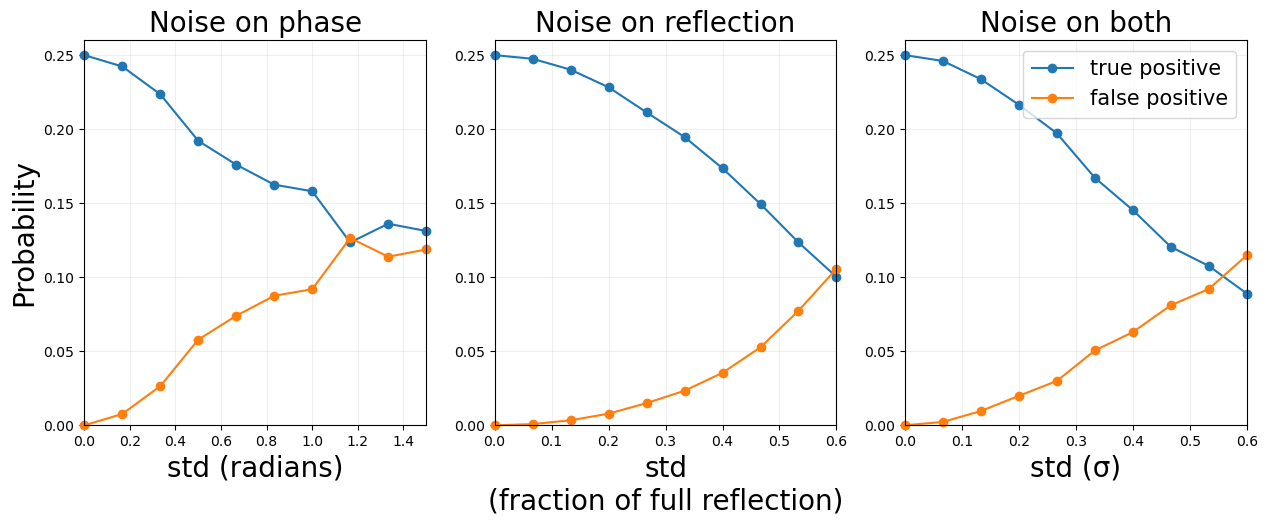

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

l1 = ax[3].plot(σlist_both, truepositive_both, label="true positive", marker="o")
l2 = ax[3].plot(σlist_both, falsepositive_both, label="false positive", marker="o")
l1[1].set_clip_on(false)
l2[1].set_clip_on(false)
ax[3].set_xlim(σlist_both[1], σlist_both[end])

l1 = ax[2].plot(σlist_reflection, truepositive_reflection, marker="o")
l2 = ax[2].plot(σlist_reflection, falsepositive_reflection, marker="o")
l1[1].set_clip_on(false)
l2[1].set_clip_on(false)
ax[2].set_xlim(σlist_reflection[1], σlist_reflection[end])

l1 = ax[1].plot(σlist_phase, truepositive_phase, marker="o")
l2 = ax[1].plot(σlist_phase, falsepositive_phase, marker="o")
l1[1].set_clip_on(false)
l2[1].set_clip_on(false)
ax[1].set_xlim(σlist_phase[1], σlist_phase[end])

for i in 1:3
    ax[i].set_ylim(0, 0.26)
    ax[i].grid(true, alpha=0.2)
end
ax[3].legend(fontsize=15, loc=1)
ax[1].set_ylabel("Probability", fontsize=20)
ax[1].set_xlabel("std (radians)", fontsize=20)
ax[2].set_xlabel("std\n(fraction of full reflection)", fontsize=20)
ax[3].set_xlabel("std (σ)", fontsize=20)

ax[1].set_title("Noise on phase", fontsize=20)
ax[2].set_title("Noise on reflection", fontsize=20)
ax[3].set_title("Noise on both", fontsize=20)
plt.savefig("quitter_noise_analysis.pdf")
plt.show()